# Pressure-Temperature Profiles

In this notebook, we summarise the main pressure-temperature (P-T) profiles in POSEIDON.

1. Madhu
- From Madhusudhan & Seager (2009), Equations 1 and 2 (https://ui.adsabs.harvard.edu/abs/2009ApJ...707...24M/abstract)
2. Guillot 
- From Guillot (2010), Equation 29 (https://ui.adsabs.harvard.edu/abs/2010A%26A...520A..27G/abstract)
- Two versions: Guillot (redistribution factor f = 0.25 for terminators or directly imaged exoplanets) and Dayside Guillot (f = 0.5 for hot Jupiter daysides)
3. Line
- From Line et al (2013), Equation 13 (https://ui.adsabs.harvard.edu/abs/2013ApJ...775..137L/abstract)
4. Pelletier
- From Pelletier et al (2021), (Section 3.5) (https://ui.adsabs.harvard.edu/abs/2021AJ....162...73P/abstract)
- Uses 'knots' to fit the PT profile with a second derivative penalty. Used for retrievals. 
5. Slope
- From Piette & Madhusudhan (2021) (https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.5136P/abstract)

Other, more simple, profiles (such as an isotherm or gradient profile are also covered in previous tutorials).

If you use any of the following profiles, please cite the pertinent work above.

**Configure Forward Model**

We use HD 189733b to showcase how to define the new PT profiles

In [22]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, wl_grid_constant_R
import numpy as np

#***** Model wavelength grid *****#

wl_min = 0.2    # Minimum wavelength (um)
wl_max = 30     # Maximum wavelength (um)
R = 5000        # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J   # Planetary mass (kg)
T_eq = 1200       # Equilibrium temperature (K)

planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

#***** Define stellar properties *****#

R_s = 0.78*R_Sun   # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13       # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58     # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

## Madhusudhan & Seager


This profile has six free parameters: $a_1$, $a_2$, $\log P_1$, $\log P_2$, $\log P_3$, and $T_{\rm{ref}}$.

With the six parameters, a three region pressure-temperature profile is formulated.

$P = P_0 e^{a_1 \sqrt{T-T_0}} \qquad (P_0 < P < P_1) \qquad (\mathrm{Region~1})$

$P = P_2 e^{a_2 \sqrt{T-T_2}} \qquad (P_1 < P < P_3) \qquad (\mathrm{Region~2})$

$T = T_3 \qquad (P < P_3) \qquad (\mathrm{Region~3})$

where $P_0$ and $T_0$ are the pressure and temperature at the top of the atmosphere, $P_{1,3}$ and $T_{1,3}$ are specified at region boundaries, and $P_2$ and $T_2$ encode a potential temperature inversion point. 

Temperature gradients are controlled by $a_1$ and $a_2$.

The regions are defined by $P_1$, $P_2$, $P_3$ ($P_0$ is given by the top of atmosphere pressure).

We note that POSEIDON allows the user to specify an arbitrary reference pressure at which the $T_{\rm{ref}}$ parameter is defined, while the original Madhusudhan & Seager (2009) paper fixed this parameter to the top-of-atmosphere ($T_0$).

In [3]:
# Madhusudhan & Seager  

model_name_Madhu = 'Madhu'

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Madhu = define_model(model_name_Madhu, bulk_species, param_species, 
                           PT_profile = 'Madhu')

print(model_Madhu['PT_param_names'])

['a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref']


In [4]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref =   1.12 * R_J

a1      =   0.48  
a2      =   0.21  
log_P1  =   -4.04 
log_P2  =   -2.40 
log_P3  =   1.33  
T_ref   =   1221.6 

P_Madhu = 1.0e-2    # Pressure where T_ref is defined

PT_params = np.array([a1,a2,log_P1,log_P2,log_P3,T_ref])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Madhu = make_atmosphere(planet, model_Madhu, P, P_ref, R_p_ref, 
                                   PT_params, log_X_params, cloud_params,
                                   P_param_set = P_Madhu,         # <---- This default to 1e-2 bar for T_ref if not set
                                   )

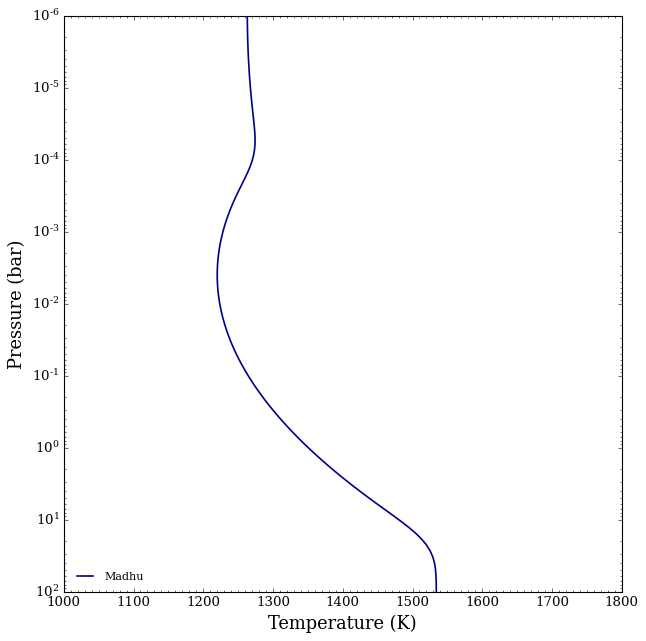

In [5]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Madhu, atmosphere_Madhu, log_P_max = 2.0)

Lets vary one parameter at at a time.

* $a_1$ controls the temperature gradient from the top of the atmosphere to log_P1:

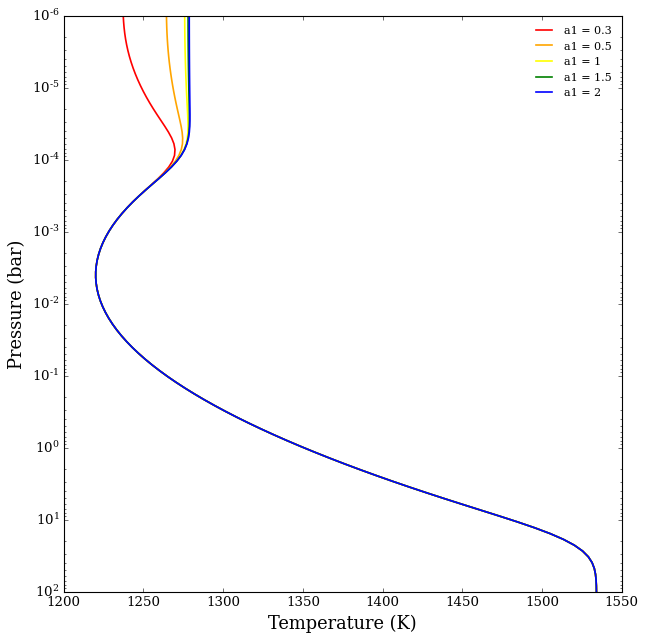

In [6]:
from POSEIDON.visuals import vary_one_parameter_PT

param_name = 'a1'
vary_list = [0.3,0.5, 1, 1.5, 2]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

* $a_2$ controls the temperature gradient from log_P1 to log_P2:

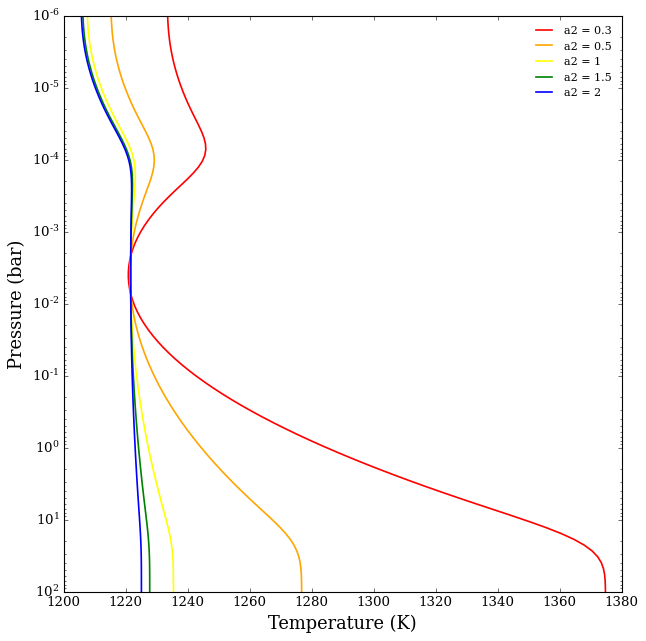

In [7]:
param_name = 'a2'
vary_list = [0.3,0.5, 1, 1.5, 2]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

* $\log P_1$ is the pressure that defines the boundary between region 1 and 2:

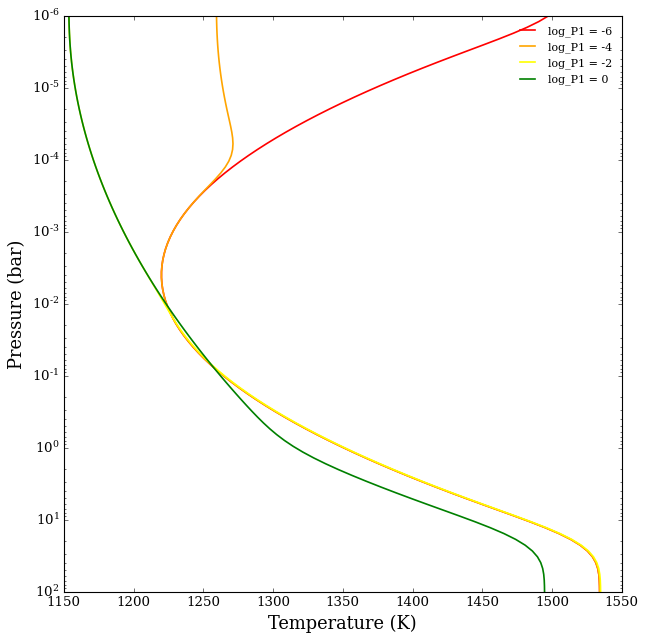

In [8]:
param_name = 'log_P1'
vary_list = [-6, -4, -2, 0]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

* $\log P_2$ is the pressure that defines a potential inversion point:

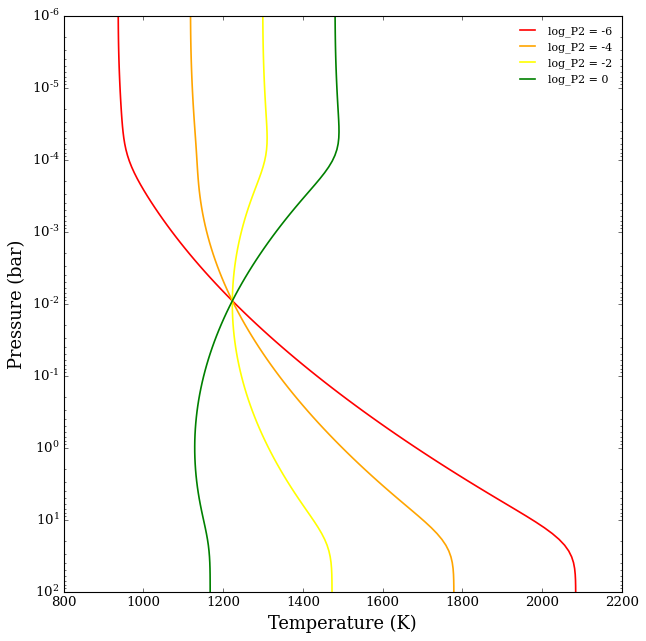

In [9]:
param_name = 'log_P2'
vary_list = [-6, -4, -2, 0]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

$\log P_3$ is the pressure that defines the boundary between region 2 and 3:

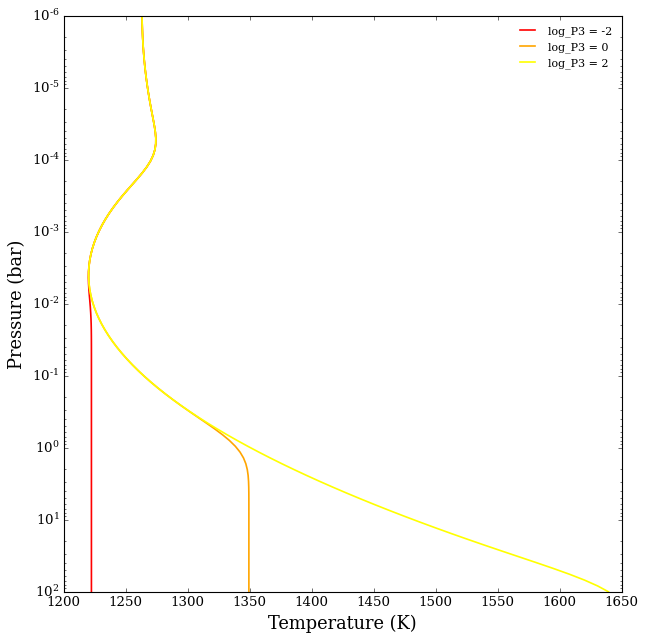

In [10]:
param_name = 'log_P3'
vary_list = [-2, 0, 2]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

* $T_{\rm{ref}}$ is the temperature at a reference pressure (here 10 mbar):

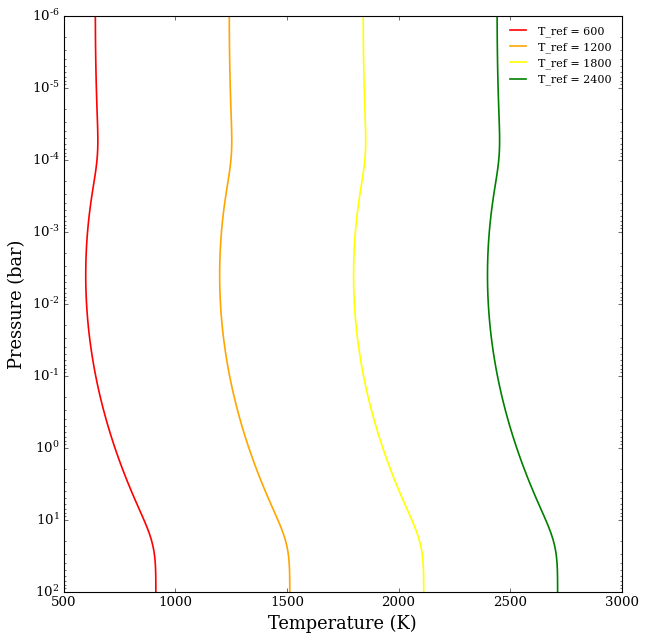

In [11]:
param_name = 'T_ref'
vary_list = [600, 1200, 1800, 2400]

vary_one_parameter_PT(model_Madhu, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

## Dayside Guillot

This profile has four free parameters:

* $\log \kappa_{IR}$: The 'infrared' opacity 

* $\log \gamma$: The ratio between optical and IR opacity

* $T_{\rm{int}}$: Internal temperature

* $T_{\rm{equ}}$: 'Equilibrium' temperature 

where the free parameters are used to compute 

$T_{irr} = \sqrt{2}T_{eq}$, and the `infrared optical depth', $\tau = P \kappa_{IR}/g$

which are plugged into

$T^4 = \frac{3T_{int}^4}{4} \left(\frac{2}{3} + \tau\right) \notag \hspace{2pt} + f\frac{3T_{irr}^4}{4}\left(\frac{2}{3} + \frac{1}{\gamma\sqrt{3}} + \left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right)$

In [21]:
# Guillot Dayside 

model_name_Guillot_dayside = 'Guillot_dayside'

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Guillot_dayside = define_model(model_name_Guillot_dayside, bulk_species, param_species, 
                                     PT_profile = 'Guillot_dayside')

print(model_Guillot_dayside['PT_param_names'])

['log_kappa_IR' 'log_gamma' 'T_int' 'T_equ']


Lets set up some parameters and an atmosphere object

In [15]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref = 1.12 * R_J

log_kappa_IR =   -4.83 
log_gamma    =   -0.41 
T_int        =   262.8
T_equ        =   1158.0 

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Guillot_dayside = make_atmosphere(planet, model_Guillot_dayside, P, P_ref, R_p_ref, 
                                             PT_params, log_X_params, cloud_params)

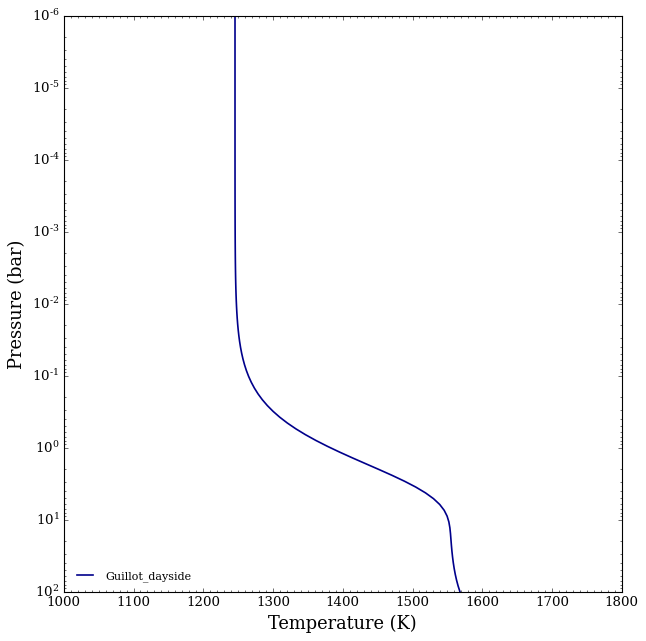

In [16]:
# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Guillot_dayside, atmosphere_Guillot_dayside, log_P_max = 2.0)

Lets see what varying the different parameters does.

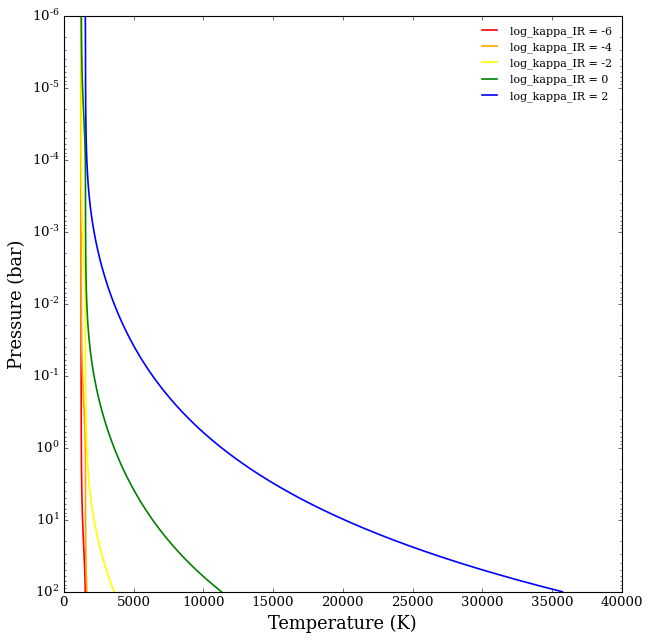

In [17]:
param_name = 'log_kappa_IR'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

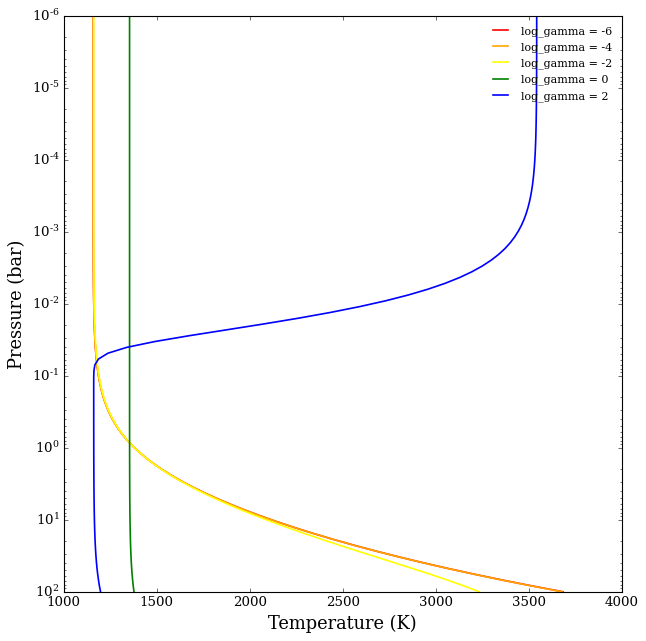

In [18]:
param_name = 'log_gamma'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

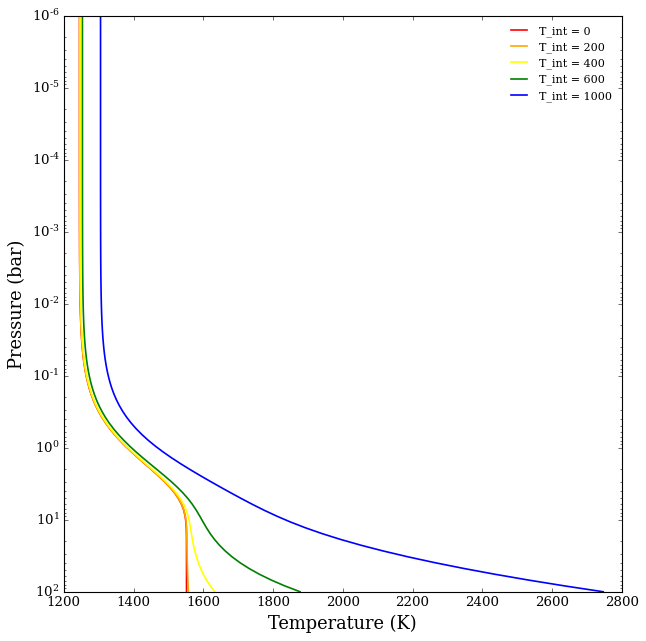

In [19]:
param_name = 'T_int'
vary_list = [0,200,400,600,1000]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

For normal profiles, $T_{\rm{equ}}$ is typically the value for which the upper profile becomes isothermal.

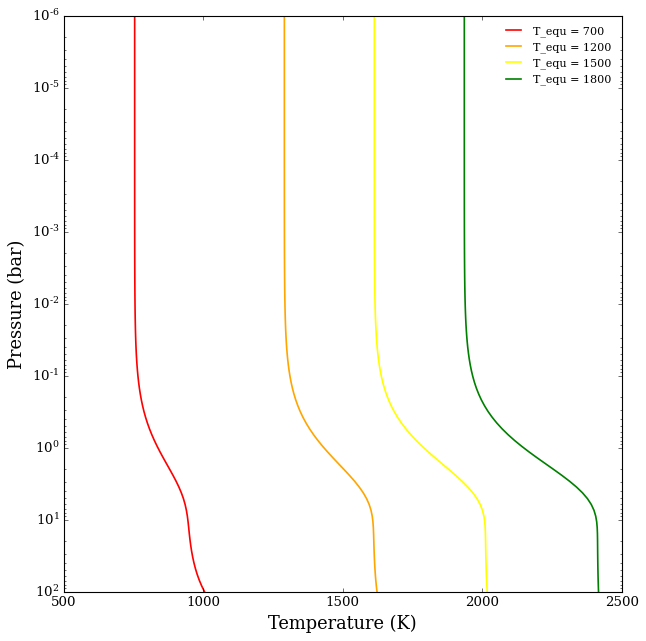

In [20]:
param_name = 'T_equ'
vary_list = [700,1200,1500,1800]

vary_one_parameter_PT(model_Guillot_dayside, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

## Line

This profile has six free parameters:

* $\log \kappa_{IR}$: The 'infrared' opacity 

* $\log \gamma$: ratio between optical and IR opacity (channel 1)

* $\log \gamma_2$: ratio between optical and IR opacity (channel 2)

* $\alpha$: partitions the flux between channel 1 and 2 (ranges 0 to 1)

* $\beta$: a `catch-all' term for heat redistribution, geometric arguments, emissivity, albedo, and errors in the equilibrium temperature

* $T_{\rm{int}}$: Internal temperature

where the free parameters are used to compute 

$T_{irr} = \beta T_{eq}$, and the `infrared optical depth', $\tau = P \kappa_{IR}/g$

which are plugged into

$
T^4 = \frac{3T_{int}^4}{4}\left(\frac{2}{3} + \tau\right) + \frac{3T_{irr}^4}{4}\left(1-\alpha\right)\xi_{\gamma}(\tau) + \frac{3T_{irr}^4}{4}\alpha\xi_{\gamma2}(\tau)
$

where $\xi$ is given by equation 14 in Line 2013.

Note that, unlike the Guillot profile, T_eq is NOT a free parameter and MUST be passed into the planet object. Additionally, the Line profile reduces down to the Guillot profile when alpha = 1. 

In [23]:
model_name_Line = 'Line'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Line = define_model(model_name_Line, bulk_species, param_species, 
                          PT_profile = 'Line')

print(model_Line['PT_param_names'])

['log_kappa_IR' 'log_gamma' 'log_gamma_2' 'alpha_Line' 'beta_Line' 'T_int']


In [26]:
# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref = 1.12 * R_J

log_kappa_IR =   -4.69 
log_gamma    =   -0.31 
log_gamma_2  =   -1.37 
alpha_Line   =   0.11 
beta_Line    =   1.13 
T_int        =   258.8 

PT_params = np.array([log_kappa_IR, log_gamma, log_gamma_2, alpha_Line, beta_Line, T_int])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Line = make_atmosphere(planet, model_Line, P, P_ref, R_p_ref, 
                                  PT_params, log_X_params, cloud_params)

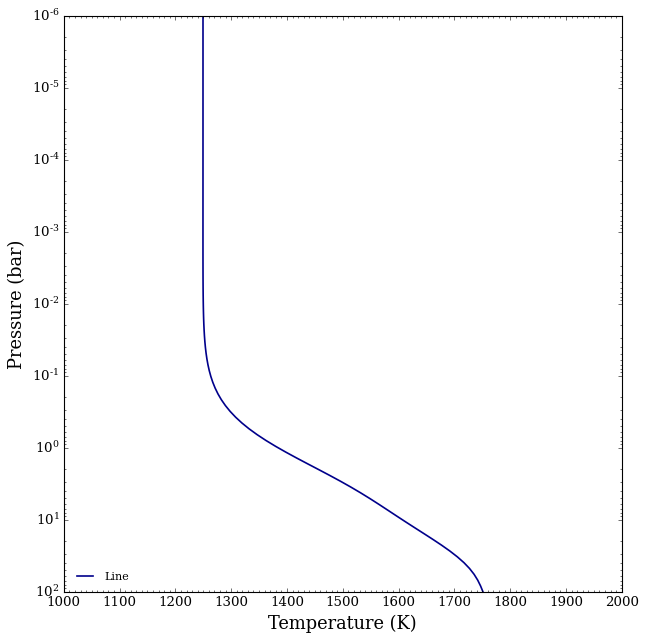

In [27]:
# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Line, atmosphere_Line, log_P_max = 2.0)

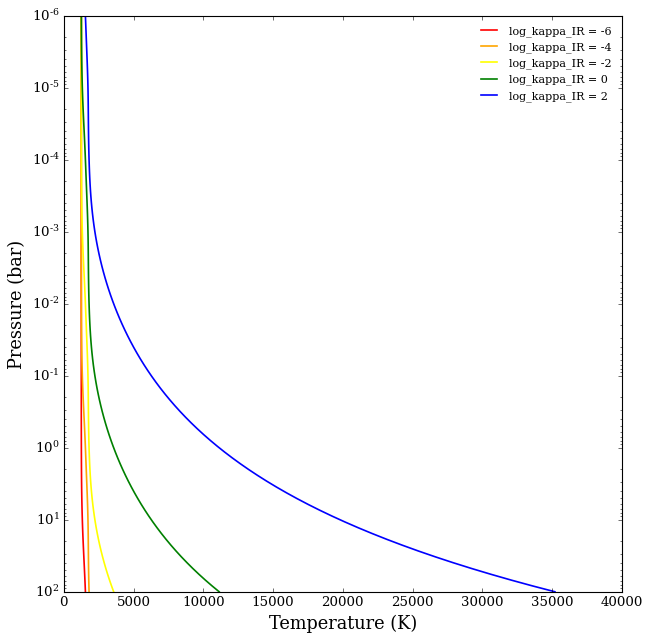

In [6]:
param_name = 'log_kappa_IR'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

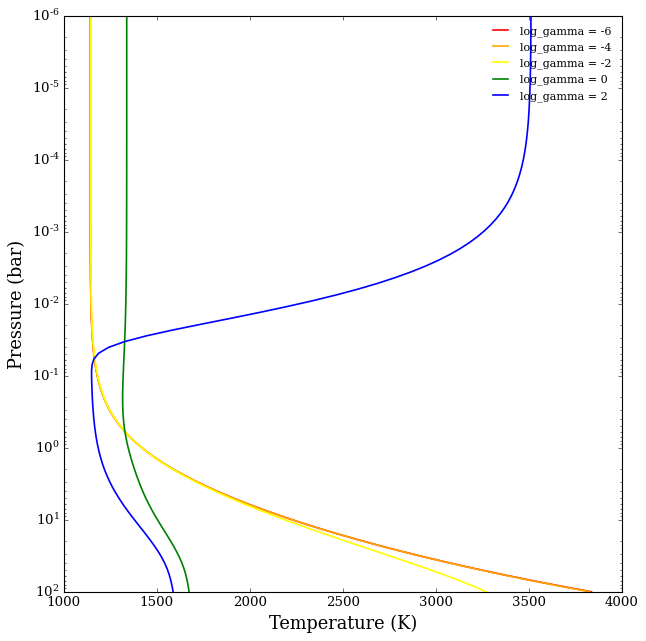

In [7]:
param_name = 'log_gamma'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

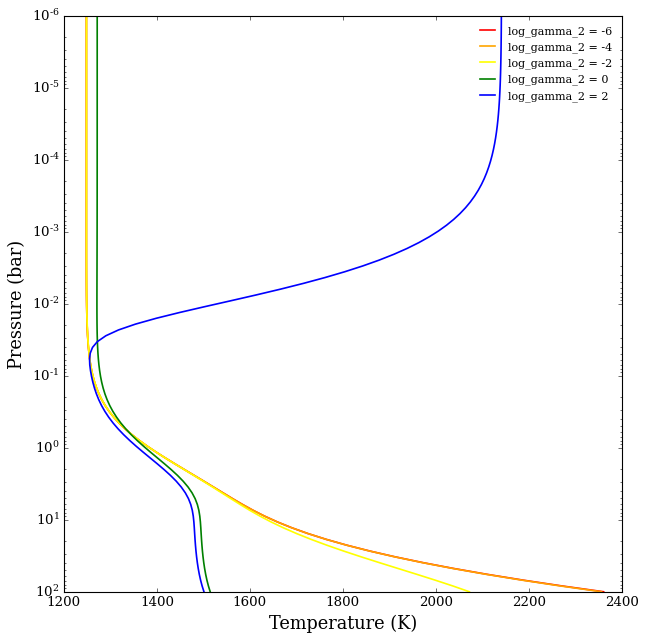

In [8]:
param_name = 'log_gamma_2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

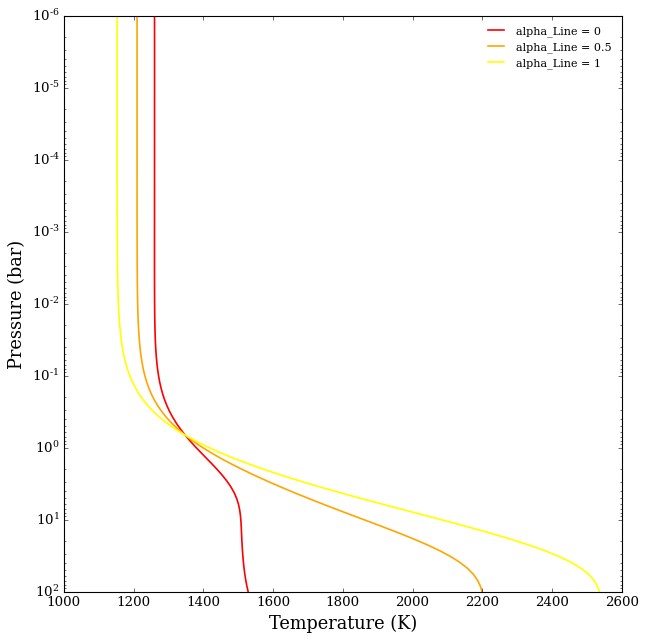

In [9]:
param_name = 'alpha_Line'
vary_list = [0,0.5,1]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

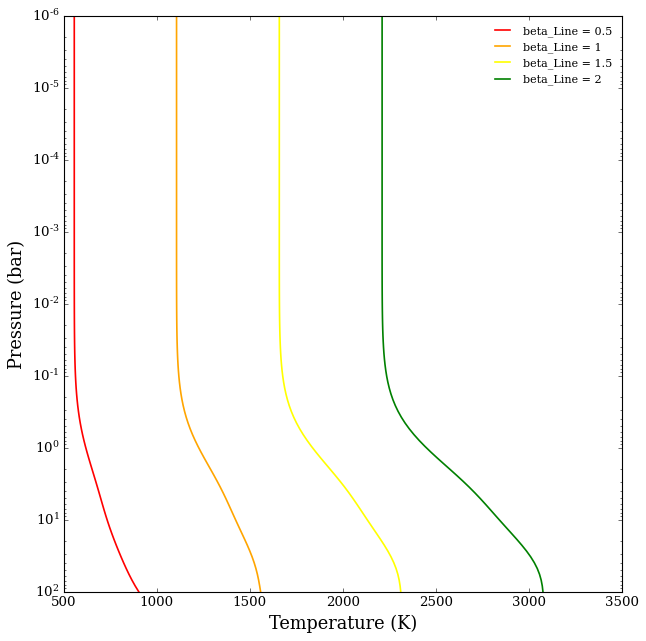

In [10]:
param_name = 'beta_Line'
vary_list = [0.5,1,1.5,2]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

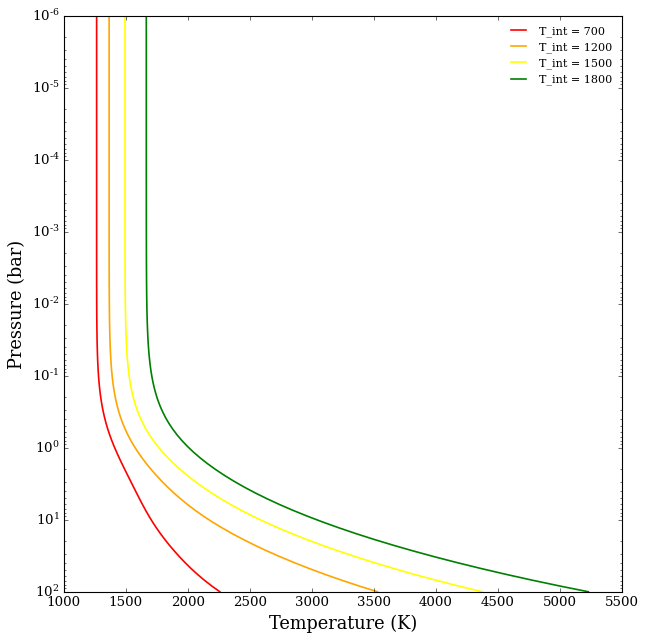

In [29]:
param_name = 'T_int'
vary_list = [700,1200,1500,1800]

vary_one_parameter_PT(model_Line, planet, param_name, vary_list,
                       P, P_ref, R_p_ref,
                       PT_params, log_X_params, cloud_params,
                       )

## Pelletier 

This profile has no set number of parameters. 

It generated a uniform number of knots in between P_min and P_max.

Below, I have 9 knots, which will set the knots to be at each pressure level (2,1,0,-1,-2,-3,-4,-5,-6) bars.

T_1 represents the top of the atmosphere (1e-6 bars) and T_9 represents the bottom (1e2 bars)

Additionally, this model is primarily used in retrievals where it has a second derivative penalty on the PT profile (to prevent it from getting too wriggly)

This parameter is called sigma_s and is fit for during a retrieval. We reccomend setting a pretty tight prior on this parameter.

(For example, for 150 is a strict second derivative prior while 550 is not. The priors I set were +/- 20 that value.)

In [30]:
model_name_Pelletier = 'Pelletier'

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_Pelletier = define_model(model_name_Pelletier, bulk_species, param_species, 
                               PT_profile = 'Pelletier',
                               number_P_knots = 9, PT_penalty = True)

print(model_Pelletier['PT_param_names'])

['T_1' 'T_2' 'T_3' 'T_4' 'T_5' 'T_6' 'T_7' 'T_8' 'T_9' 'sigma_s']


Results from sigma_s = 150

In [31]:
# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref =  1.12 * R_J

T_1     =   1222.7 
T_2     =   1176.1
T_3     =   1172.5
T_4     =   1162.1
T_5     =   1179.5
T_6     =   1258.0
T_7     =   1368.8
T_8     =   1564.1
T_9     =   1775.1 
sigma_s =   155.54 

PT_params = np.array([T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,sigma_s])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Pelletier = make_atmosphere(planet, model_Pelletier, P, P_ref, R_p_ref, 
                                       PT_params, log_X_params, cloud_params)

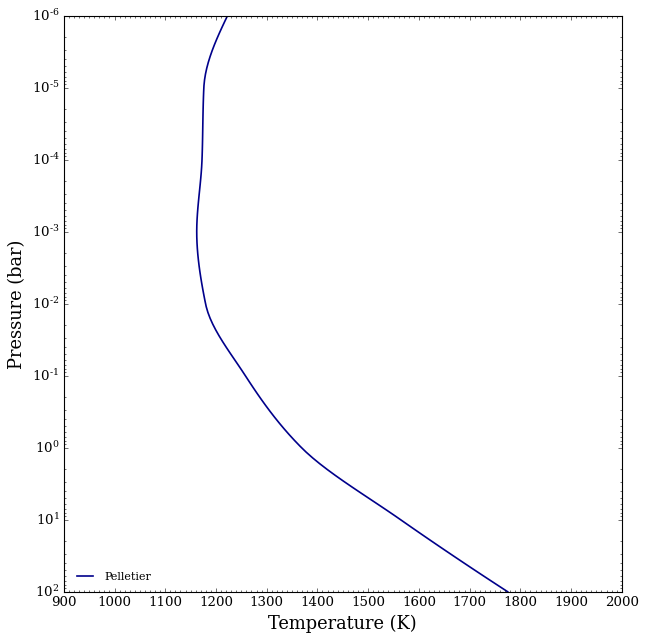

In [32]:
# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Pelletier, atmosphere_Pelletier, log_P_max = 2.0)

Now from the more 'relaxed' sigma_s = 550

In [33]:
# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref = 1.12 * R_J

T_1     =   835.0 
T_2     =   732.9 
T_3     =   982.5  
T_4     =   1631.1
T_5     =   540.1  
T_6     =   1378.0 
T_7     =   2213.9 
T_8     =   1957.9 
T_9     =   1624.7 
sigma_s =   552.50 

PT_params = np.array([T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,sigma_s])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_Pelletier = make_atmosphere(planet, model_Pelletier, P, P_ref, R_p_ref, 
                                       PT_params, log_X_params, cloud_params)

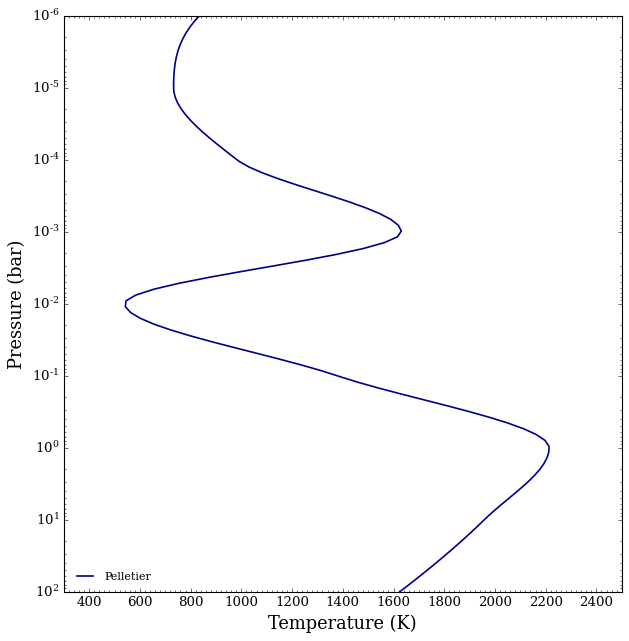

In [34]:
# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_Pelletier, atmosphere_Pelletier, log_P_max = 2.0)

Its a lot more wriggly! Like we would expect.

## Slope 

This profile has as many free parameters as the user specifies.

The original P-T profile, as defined in Piette & Madhusudhan (2021), fits for a photospheric temperature at 3.16 bars and a fixed number of $\Delta$ T parameters between specific pressure anchor points (e.g., $\Delta T$ from 10 to 1\,mbar). 

The implementation here allows the user to define the pressure of the photosphere and the pressure edges where the $\Delta T$ parameters are defined (i.e., the number of $\Delta T$ parameters is a user choice). This parameterization is much better suited than other P-T profiles at fitting a deep temperature adiabat with a decreasing temperature with height. 

The slope profile explicitly assumes monotonically decreasing temperature with altitude and thus does not allow for thermal inversions (i.e., the $\Delta T > 0$).

Below: The photosphere is defined at 1e-1 bars with $\Delta T_1$ from 1e-6 to 1e-5 bars, $\Delta T_2$ from 1e-5 to 1e-4 bars, and so forth. $T_{\rm{phot}}$ acts as the anchor point.

In [35]:
model_name_slope = 'Slope'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = []

# Create the model object
model_slope = define_model(model_name_slope, bulk_species, param_species, 
                           PT_profile = 'slope',
                           log_P_slope_phot = -1,
                           log_P_slope_arr = [-6.0, -5.0, -4.0, -3.0, -2.0, 0.0, 1.0, 2.0,])

In [36]:
from POSEIDON.core import make_atmosphere

# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # The R_p_ref parameter will be the radius at 1 bar

# Free parameters
R_p_ref = 1.12 * R_J

T_phot_PT =   1281.8 
Delta_T_1 =   228.4 
Delta_T_2 =   189.0 
Delta_T_3 =   190.0 
Delta_T_4 =   137.9 
Delta_T_5 =   67.2 
Delta_T_6 =   81.7 
Delta_T_7 =   221.3 
Delta_T_8 =   477.7

PT_params = np.array([T_phot_PT, Delta_T_1, Delta_T_2, Delta_T_3, Delta_T_4, Delta_T_5, Delta_T_6, Delta_T_7, Delta_T_8])
log_X_params = np.array([])
cloud_params = np.array([])

atmosphere_slope = make_atmosphere(planet, model_slope, P, P_ref, R_p_ref, 
                                   PT_params, log_X_params, cloud_params)

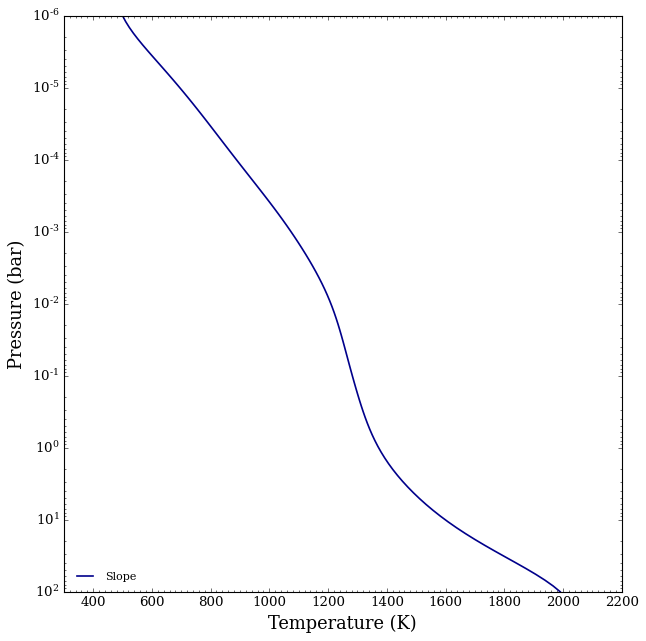

In [37]:
# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_slope, atmosphere_slope, log_P_max = 2.0)